In [1]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [2]:
import csv
import numpy as np
import pandas as pd
import os
from collections import Counter

# Required RDKit modules
import rdkit as rd
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import RDConfig
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
from rdkit.Chem import AllChem as Chem
from rdkit.Chem.rdMolDescriptors import GetAtomPairFingerprint
from rdkit.Chem.AtomPairs import Torsions
from rdkit.Chem import AllChem, Descriptors
from rdkit.Chem import rdMolDescriptors

# modeling
import sklearn as sk
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
import xgboost

# Graphing
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
frame = PandasTools.LoadSDF('fda_stok.sdf',smilesName='SMILES',molColName='Molecule', includeFingerprints=True)
frame = frame.drop(['ID', 'Molecule', 'smiles'], axis=1)

In [4]:
frame["mol"] = [Chem.MolFromSmiles(x) for x in frame["SMILES"]]

,zinc_id,SMILES,mol
0,ZINC000001530427,C[C@@H]1O[C@@H]1P(=O)(O)O,
1,ZINC000003807804,Clc1ccccc1C(c1ccccc1)(c1ccccc1)n1ccnc1,
2,ZINC000000120286,Nc1nc(N)c2nc(-c3ccccc3)c(N)nc2n1,
3,ZINC000242548690,C[C@H]1O[C@@H](O[C@H]2[C@@H](O)C[C@H](O[C@H]3[...,
4,ZINC000000008492,Oc1cccc2cccnc12,
...,...,...,...
1610,ZINC000022010387,C[C@H]1[C@H](c2ccccc2)OCCN1C,
1611,ZINC000022448097,CCOc1ccc(C[C@@H](CN(CCN(CC(=O)O)CC(=O)O)CC(=O)...,
1612,ZINC000100370145,CC1(C)[C@H]2CC[C@@]1(CS(=O)(=O)O)C(=O)/C2=C/c1...,
1613,ZINC000059111167,[C-]#[N+]CC(C)(C)OC,

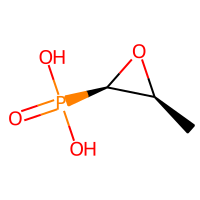
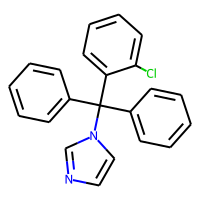
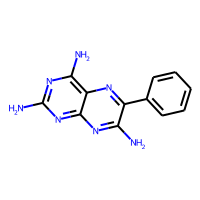
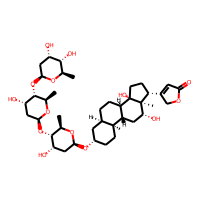
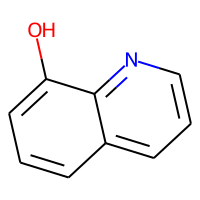
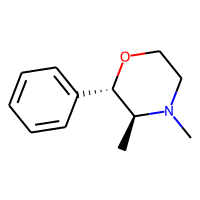
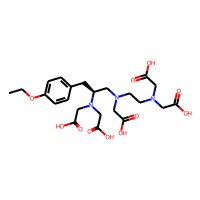
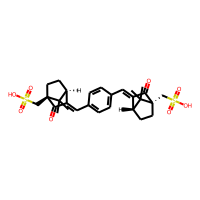
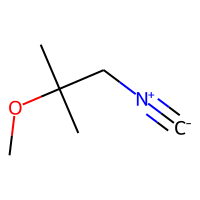
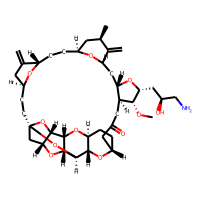

In [5]:
frame

In [6]:
fingerprints = pd.DataFrame()
fingerprints["morgan"] = [Chem.GetMorganFingerprintAsBitVect(m, 2, nBits = 2048) for m in frame['mol']]
fingerprints["daylight"] = [Chem.RDKFingerprint(m) for m in frame["mol"]]
fingerprints["atompair"] = [Chem.GetHashedAtomPairFingerprintAsBitVect(m) for m in frame["mol"]]
fingerprints["torsion"] = torsion_fp = [Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(m) for m in frame["mol"]]

In [7]:
descr = []
for m in frame["mol"]:
    descr.append(np.array([Descriptors.BalabanJ(m),
                           Descriptors.BertzCT(m),
                           Descriptors.Ipc(m),
                           Descriptors.HallKierAlpha(m),
                           Descriptors.Kappa1(m),
                           Descriptors.Kappa2(m),
                           Descriptors.Kappa3(m),
                           Descriptors.Chi0(m),
                           Descriptors.Chi1(m),
                           Descriptors.Chi0n(m),
                           Descriptors.Chi1n(m),
                           Descriptors.Chi0v(m),
                           Descriptors.Chi1v(m),
                           Descriptors.Chi2v(m),
                           Descriptors.Chi3v(m),
                           Descriptors.MolMR(m),
                           Descriptors.MolWt(m),
                           Descriptors.ExactMolWt(m),
                           Descriptors.HeavyAtomCount(m),
                           Descriptors.HeavyAtomMolWt(m),
                           Descriptors.NumHAcceptors(m),
                           Descriptors.NumHDonors(m),
                           Descriptors.NumHeteroatoms(m),
                           Descriptors.NumRotatableBonds(m),
                           Descriptors.NumValenceElectrons(m),
                           #Descriptors.NumAmideBonds(m),
                           Descriptors.NumAromaticRings(m),
                           Descriptors.NumSaturatedRings(m),
                           Descriptors.NumAliphaticRings(m),
                           Descriptors.NumAromaticHeterocycles(m),
                           Descriptors.NumSaturatedHeterocycles(m),
                           Descriptors.NumAliphaticHeterocycles(m),
                           Descriptors.NumAromaticCarbocycles(m),
                           Descriptors.NumSaturatedCarbocycles(m),
                           Descriptors.NumAliphaticCarbocycles(m),
                           Descriptors.RingCount(m),
                           Descriptors.FractionCSP3(m),
                           #Descriptors.NumSpiroAtoms(m),
                           #Descriptors.NumBridgeheadAtoms(m),
                           Descriptors.TPSA(m),
                           Descriptors.LabuteASA(m),
                           Descriptors.PEOE_VSA1(m),
                           Descriptors.PEOE_VSA2(m),
                           Descriptors.PEOE_VSA3(m),
                           Descriptors.PEOE_VSA4(m),
                           Descriptors.PEOE_VSA5(m),
                           Descriptors.PEOE_VSA6(m),
                           Descriptors.PEOE_VSA7(m),
                           Descriptors.PEOE_VSA8(m),
                           Descriptors.PEOE_VSA9(m),
                           Descriptors.PEOE_VSA10(m),
                           Descriptors.PEOE_VSA11(m),
                           Descriptors.PEOE_VSA12(m),
                           Descriptors.PEOE_VSA13(m),
                           Descriptors.PEOE_VSA14(m),
                           Descriptors.SMR_VSA1(m),
                           Descriptors.SMR_VSA2(m),
                           Descriptors.SMR_VSA3(m),
                           Descriptors.SMR_VSA4(m),
                           Descriptors.SMR_VSA5(m),
                           Descriptors.SMR_VSA6(m),
                           Descriptors.SMR_VSA7(m),
                           Descriptors.SMR_VSA8(m),
                           Descriptors.SMR_VSA9(m),
                           Descriptors.SMR_VSA10(m),
                           Descriptors.SlogP_VSA1(m),
                           Descriptors.SlogP_VSA2(m),
                           Descriptors.SlogP_VSA3(m),
                           Descriptors.SlogP_VSA4(m),
                           Descriptors.SlogP_VSA5(m),
                           Descriptors.SlogP_VSA6(m),
                           Descriptors.SlogP_VSA7(m),
                           Descriptors.SlogP_VSA8(m),
                           Descriptors.SlogP_VSA9(m),
                           Descriptors.SlogP_VSA10(m),
                           Descriptors.SlogP_VSA11(m),
                           Descriptors.SlogP_VSA12(m),
                           Descriptors.EState_VSA1(m),
                           Descriptors.EState_VSA2(m),
                           Descriptors.EState_VSA3(m),
                           Descriptors.EState_VSA4(m),
                           Descriptors.EState_VSA5(m),
                           Descriptors.EState_VSA6(m),
                           Descriptors.EState_VSA7(m),
                           Descriptors.EState_VSA8(m),
                           Descriptors.EState_VSA9(m),
                           Descriptors.EState_VSA10(m),
                           Descriptors.EState_VSA11(m),
                           Descriptors.VSA_EState1(m),
                           Descriptors.VSA_EState2(m),
                           Descriptors.VSA_EState3(m),
                           Descriptors.VSA_EState4(m),
                           Descriptors.VSA_EState5(m),
                           Descriptors.VSA_EState6(m),
                           Descriptors.VSA_EState7(m),
                           Descriptors.VSA_EState8(m),
                           Descriptors.VSA_EState9(m),
                           Descriptors.VSA_EState10(m),
                           Descriptors.MolLogP(m),
                           Descriptors.NHOHCount(m),
                           Descriptors.NOCount(m),
                          ]))
fingerprints["desc"] = descr
numberOfDescriptors = len(descr[0])

In [8]:
fingerprints

,morgan,daylight,atompair,torsion,desc
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.517285418866277, 138.21884910034808, 74.656..."
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, ...","[2.153583648156872, 908.2706613028778, 1236605..."
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[2.3078316699480332, 754.8677985188037, 27245...."
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, ...","[1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.8374981988041248, 1409.0037418555949, 14643..."
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[2.9131611636048604, 378.7244463345712, 505.76..."
...,...,...,...,...,...
1610,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...","[2.174499247830223, 285.6330203302586, 2171.55..."
1611,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.20519718581977, 891.0175363739821, 42747274..."
1612,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, ...","[1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.437782126757885, 1397.3474102675675, 138191..."
1613,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3.5806290680599435, 101.58638780895905, 41.81..."


In [9]:
def GetFingerPrintList(frame, name, includeDescriptors=True):
    fingerprint_np = []
    for fp, ap in zip(frame[name].values,frame["desc"].values) :
      arr = np.zeros((1,))
      DataStructs.ConvertToNumpyArray(fp, arr)
      if includeDescriptors:
          arr = np.concatenate((arr, np.array(ap)), axis=None)
      fingerprint_np.append(arr)
    return fingerprint_np

In [10]:
results = pd.read_csv("results.csv", header=None)
results.columns = ["ID", "Vina1", "Vina2", "Vina3", "ZincID", "Smile"]
results = results.drop(['ID', 'Smile'], axis=1)

In [11]:
results

,Vina1,Vina2,Vina3,ZincID
0,-3.9,-3.8,-3.8,ZINC000001530427
1,-7.0,-6.7,-6.6,ZINC000003807804
2,-7.1,-7.0,-7.0,ZINC000000120286
3,-8.9,-8.7,-8.7,ZINC000242548690
4,-5.7,-5.5,-5.5,ZINC000000008492
...,...,...,...,...
1610,-5.4,-5.3,-5.3,ZINC000022010387
1611,-5.6,-5.4,-5.2,ZINC000022448097
1612,-9.1,-9.0,-8.9,ZINC000100370145
1613,-3.5,-3.4,-3.4,ZINC000059111167


In [12]:
#remove rows with 0 vina scores
zero_rows = results.index[results['Vina1'] == 0]
results.drop(zero_rows, inplace=True)
fingerprints.drop(zero_rows, inplace=True)

In [13]:
y = results['Vina1'].to_numpy()

In [14]:
y = results['Vina1'].div(-12).to_numpy()

In [15]:
x_morgan = pd.DataFrame(GetFingerPrintList(fingerprints, "morgan"))
x_day = pd.DataFrame(GetFingerPrintList(fingerprints, "daylight"))
x_atom = pd.DataFrame(GetFingerPrintList(fingerprints, "atompair"))
x_tor = pd.DataFrame(GetFingerPrintList(fingerprints, "torsion"))

In [16]:
scale = RobustScaler().fit(x_morgan)
x_morgan = pd.DataFrame(scale.transform(x_morgan))

scale = RobustScaler().fit(x_day)
x_day = pd.DataFrame(scale.transform(x_day))

scale = RobustScaler().fit(x_atom)
x_atom = pd.DataFrame(scale.transform(x_atom))

scale = RobustScaler().fit(x_tor)
x_tor = pd.DataFrame(scale.transform(x_tor))

In [17]:
x_morg_train, x_morg_test, y_morg_train, y_morg_test = \
    train_test_split(x_morgan, y, test_size=0.15, random_state=1)

x_day_train, x_day_test, y_day_train, y_day_test = \
    train_test_split(x_day, y, test_size=0.15, random_state=1)

x_atom_train, x_atom_test, y_atom_train, y_atom_test = \
    train_test_split(x_atom, y, test_size=0.15, random_state=1)

x_tor_train, x_tor_test, y_tor_train, y_tor_test = \
    train_test_split(x_tor, y, test_size=0.15, random_state=1)

In [18]:
x_morg_train

,0,1,2,3,4,5,6,7,8,9,...,2136,2137,2138,2139,2140,2141,2142,2143,2144,2145
400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.457929,0.000000,1.769584,0.440659,-0.536927,0.000000,0.000000,0.632144,-1.0,-0.25
1474,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.417849,0.000000,-0.521852,-4.432640,1.671133,0.000000,0.000000,-1.608286,3.0,3.50
51,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.087651,0.000000,0.448545,-0.091403,-0.084218,1.217552,0.000000,-0.251576,-0.5,-1.00
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.628545,0.129851,-0.521852,-0.672280,1.510987,0.000000,0.000000,-0.122102,2.0,2.25
1579,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.474923,-0.393902,-0.521852,0.738439,1.791598,1.013148,0.000000,0.292345,0.5,1.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.282224,0.042647,0.075390,-0.337128,1.114328,0.000000,4.690856,0.245223,-0.5,-0.75
905,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.224042,-0.546945,0.393534,0.607145,-0.579564,1.323739,0.000000,-0.219675,-0.5,-0.25
1096,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.200756,-0.353601,0.742972,-0.654995,-0.536927,0.000000,4.828043,-0.044030,0.0,-0.25
235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.417849,0.000000,-0.521852,-0.337128,2.007819,1.944555,8.559655,0.354585,-1.0,-0.75


In [19]:
def eval_model(model_, xtrain_, ytrain_, xtest_, ytest_):
    plt.figure(figsize=(16,8))
    plt.subplot(1, 2, 1)
    ypred_ = model_.predict(xtrain_).reshape(len(xtrain_),1)
    df_ = pd.DataFrame({'ytrain': ytrain_[:,0], 'ypred' : ypred_[:,0]}).sort_values('ytrain', ascending=True)
    df_['x'] = range(0,len(ypred_))
    plt.plot( 'x', 'ytrain', data=df_, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'x', 'ypred', data=df_, marker='', color='red', linewidth=2)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    ypred_ = model_.predict(xtest_).reshape(len(xtest_),1)
    df__ = pd.DataFrame({'ytest': ytest_[:,0], 'ypred' : ypred_[:,0]}).sort_values('ytest', ascending=True)
    df__['x'] = range(0,len(ypred))
    plt.plot( 'x', 'ytest', data=df__, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4)
    plt.plot( 'x', 'ypred', data=df__, marker='', color='red', linewidth=2)
    plt.legend()

In [20]:
def train_xgb_model(xtrain, ytrain):
    model = xgboost.XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
           colsample_bynode=1, colsample_bytree=1, gamma=0,
           importance_type='gain', learning_rate=0.1, max_delta_step=0,
           max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
           n_jobs=1, nthread=None, objective='reg:squarederror', random_state=0,
           reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
           silent=None, subsample=1, verbosity=1)
    model.fit(xtrain, ytrain)
    score = model.score(xtrain, ytrain)  
    print("Training score: ", score)
    kfold = KFold(n_splits=10, shuffle=True)
    kf_cv_scores = cross_val_score(model, xtrain, ytrain, cv=kfold )
    print("K-fold CV average score: %.2f" % kf_cv_scores.mean())
    return model

In [21]:
model_morg = train_xgb_model(x_morg_train, y_morg_train)
ypred = model_morg.predict(x_morg_test)
mse = mean_squared_error(y_morg_test, ypred)
print("MSE: %.5f" % mse)
print("RMSE: %.5f" % (mse**(1/2.0)))

Training score:  0.9595925561376216
K-fold CV average score: 0.84
MSE: 0.00171
RMSE: 0.04136


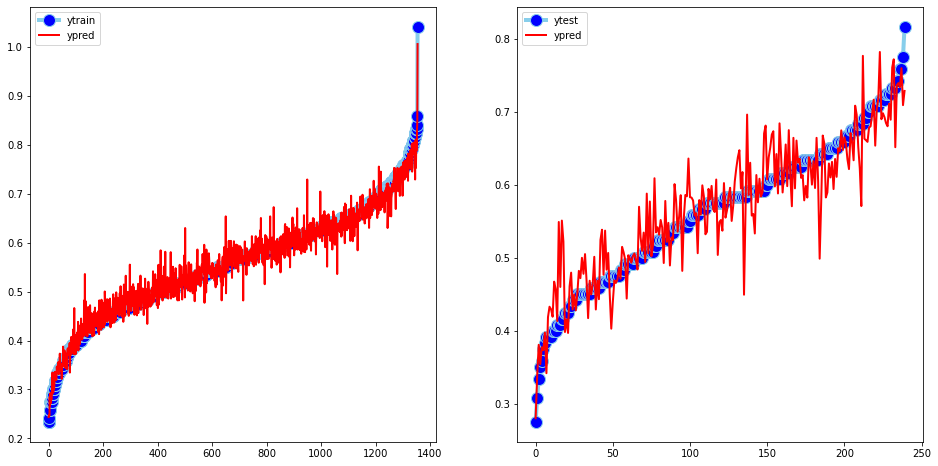

In [22]:
eval_model(model_morg, x_morg_train,
           np.array(y_morg_train).reshape(len(y_morg_train),1).astype(float),
           x_morg_test,
           np.array(y_morg_test).reshape(len(y_morg_test),1).astype(float))

In [23]:
model_day = train_xgb_model(x_day_train, y_day_train)
ypred = model_day.predict(x_day_test)
mse = mean_squared_error(y_day_test, ypred)
print("MSE: %.5f" % mse)
print("RMSE: %.5f" % (mse**(1/2.0)))

Training score:  0.9676539921230659
K-fold CV average score: 0.83
MSE: 0.00189
RMSE: 0.04346


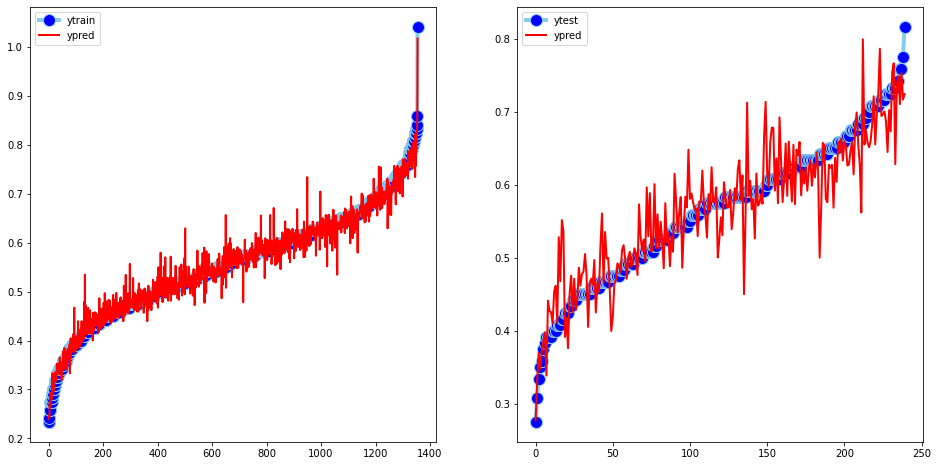

In [24]:
eval_model(model_day, x_day_train,
           np.array(y_day_train).reshape(len(y_day_train),1).astype(float),
           x_day_test,
           np.array(y_day_test).reshape(len(y_day_test),1).astype(float))

In [25]:
model_atom = train_xgb_model(x_atom_train, y_atom_train)
ypred = model_atom.predict(x_atom_test)
mse = mean_squared_error(y_atom_test, ypred)
print("MSE: %.5f" % mse)
print("RMSE: %.5f" % (mse**(1/2.0)))

Training score:  0.967952026370286
K-fold CV average score: 0.84
MSE: 0.00180
RMSE: 0.04248


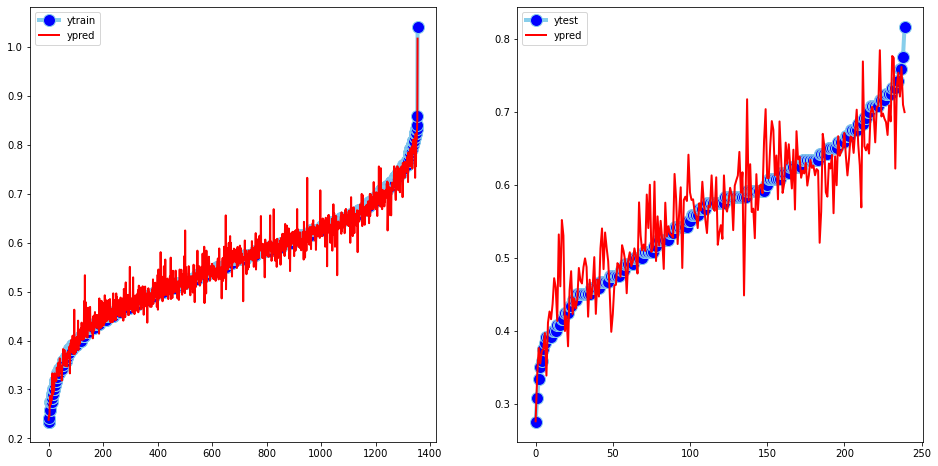

In [26]:
eval_model(model_atom, x_atom_train,
           np.array(y_atom_train).reshape(len(y_atom_train),1).astype(float),
           x_atom_test,
           np.array(y_atom_test).reshape(len(y_atom_test),1).astype(float))

In [27]:
model_tor = train_xgb_model(x_tor_train, y_tor_train)
ypred = model_tor.predict(x_tor_test)
mse = mean_squared_error(y_tor_test, ypred)
print("MSE: %.5f" % mse)
print("RMSE: %.5f" % (mse**(1/2.0)))

Training score:  0.9622164216811988
K-fold CV average score: 0.84
MSE: 0.00177
RMSE: 0.04207


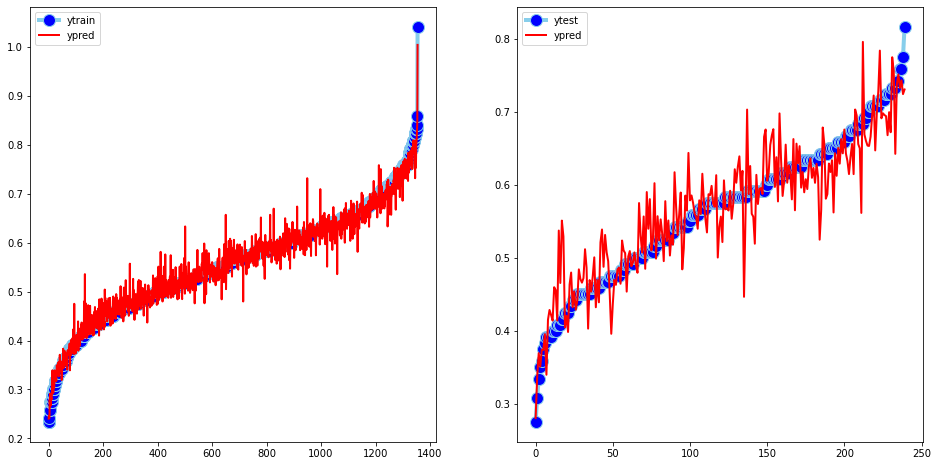

In [28]:
eval_model(model_tor, x_tor_train,
           np.array(y_tor_train).reshape(len(y_tor_train),1).astype(float),
           x_tor_test,
           np.array(y_tor_test).reshape(len(y_tor_test),1).astype(float))

# NEURAL NETWORK

In [29]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [53]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, InputLayer, BatchNormalization, GaussianNoise
from sklearn.utils import shuffle

from tensorflow.keras.regularizers import l1
from tensorflow.keras.regularizers import l2
from tensorflow.keras.regularizers import l1_l2

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model

#tf.keras.backend.set_epsilon(1)

from tensorflow.keras import losses 
from tensorflow.keras import optimizers 
from tensorflow.keras import metrics 

In [31]:
batch_size_ = 32
epochs_ = 200
verbose_ = 1

In [32]:
def scheduler(epoch):
    if epoch < 20:
        return 1.0
    else:
        return max(0.0005, 1.0 / (2**int((epoch-20)/30)))

In [33]:
def trainer(model, xtrain, ytrain):
    lrs = LearningRateScheduler(scheduler, verbose=verbose_)

    history = model.fit(xtrain, ytrain,
                        batch_size=batch_size_, epochs=epochs_, verbose=verbose_,
                        validation_split=0.15, shuffle=True,
                        callbacks=[lrs, 
                                   EarlyStopping(monitor='val_loss', patience=70),
                                   ModelCheckpoint(filepath='final_best_model.h5', 
                                                   monitor='val_loss', save_best_only=True)])
    model = load_model('final_best_model.h5')
    return model, history

In [63]:
def plot_history(history):
    plt.figure(figsize=(12,6))
    plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

In [35]:
from tensorflow.keras import backend as K

In [41]:
class RobustAdaptativeLoss(object):
  def __init__(self):
    z = np.array([[0]])
    self.v_alpha = K.variable(z)

  def loss(self, y_true, y_pred, **kwargs):
    x = y_true - y_pred
    x = K.reshape(x, shape=(-1, 1))
    with tf.compat.v1.variable_scope("lossfun", reuse=True):
      loss, alpha, scale = lossfun(x)
    op = K.update(self.v_alpha, alpha)
    return loss + 0 * op

  def alpha(self, y_true, y_pred):
    return self.v_alpha

In [58]:
def create_nn_model(d1 = 0.3, d2 = 0.5, d3 = 0.3, d4 = 0.1, d5=0):
    tf.keras.backend.clear_session()
    tf.keras.backend.set_floatx('float64')
    model =  tf.keras.Sequential()
    model.add(Dense(2048 + numberOfDescriptors, activation='linear'))
    model.add(Dropout(d1))
    #model.add(Dense(4096 + numberOfDescriptors, activation='tanh'))
    #model.add(BatchNormalization())
    #model.add(Dropout(d2))
    model.add(Dense(1024 + numberOfDescriptors, activation='tanh'))
    model.add(BatchNormalization())
    model.add(Dropout(d3))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(d4))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(d5))
    model.add(Dense(1, activation='linear'))
    
    #loss = RobustAdaptativeLoss()
    model.compile(loss = 'mean_squared_error', 
                  optimizer=tf.keras.optimizers.Adadelta(learning_rate=0.25),
                  metrics=[tf.keras.metrics.MeanSquaredError()])
    return model

# MORGAN

In [59]:
nn_morg_model = create_nn_model()
nn_morg_model_trained, history = trainer(nn_morg_model, x_morg_train,
                                         np.array(y_morg_train).reshape(len(y_morg_train),1))


Epoch 00001: LearningRateScheduler reducing learning rate to 1.0.
Epoch 1/200
36/36 [==============================] - 1s 36ms/step - loss: 1.0158 - mean_squared_error: 1.0158 - val_loss: 0.1403 - val_mean_squared_error: 0.1403 - lr: 1.0000

Epoch 00002: LearningRateScheduler reducing learning rate to 1.0.
Epoch 2/200
36/36 [==============================] - 1s 26ms/step - loss: 0.2434 - mean_squared_error: 0.2434 - val_loss: 0.1257 - val_mean_squared_error: 0.1257 - lr: 1.0000

Epoch 00003: LearningRateScheduler reducing learning rate to 1.0.
Epoch 3/200
36/36 [==============================] - 1s 16ms/step - loss: 0.1624 - mean_squared_error: 0.1624 - val_loss: 0.1779 - val_mean_squared_error: 0.1779 - lr: 1.0000

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0.
Epoch 4/200
36/36 [==============================] - 1s 28ms/step - loss: 0.1485 - mean_squared_error: 0.1485 - val_loss: 0.0730 - val_mean_squared_error: 0.0730 - lr: 1.0000

Epoch 00005: LearningRateSchedu


Epoch 00035: LearningRateScheduler reducing learning rate to 1.0.
Epoch 35/200
36/36 [==============================] - 1s 28ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - val_loss: 0.0042 - val_mean_squared_error: 0.0042 - lr: 1.0000

Epoch 00036: LearningRateScheduler reducing learning rate to 1.0.
Epoch 36/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - val_loss: 0.0233 - val_mean_squared_error: 0.0233 - lr: 1.0000

Epoch 00037: LearningRateScheduler reducing learning rate to 1.0.
Epoch 37/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0122 - mean_squared_error: 0.0122 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - lr: 1.0000

Epoch 00038: LearningRateScheduler reducing learning rate to 1.0.
Epoch 38/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0141 - mean_squared_error: 0.0141 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - lr: 1.0000

Epoch 00039: LearningRateSc


Epoch 00069: LearningRateScheduler reducing learning rate to 0.5.
Epoch 69/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - lr: 0.5000

Epoch 00070: LearningRateScheduler reducing learning rate to 0.5.
Epoch 70/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - lr: 0.5000

Epoch 00071: LearningRateScheduler reducing learning rate to 0.5.
Epoch 71/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - lr: 0.5000

Epoch 00072: LearningRateScheduler reducing learning rate to 0.5.
Epoch 72/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0051 - mean_squared_error: 0.0051 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - lr: 0.5000

Epoch 00073: LearningRateSc

36/36 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - lr: 0.2500

Epoch 00103: LearningRateScheduler reducing learning rate to 0.25.
Epoch 103/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - lr: 0.2500

Epoch 00104: LearningRateScheduler reducing learning rate to 0.25.
Epoch 104/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - lr: 0.2500

Epoch 00105: LearningRateScheduler reducing learning rate to 0.25.
Epoch 105/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - lr: 0.2500

Epoch 00106: LearningRateScheduler reducing learning rate to 0.25.
Epoch 106/200
36/36 [=============

36/36 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - lr: 0.1250

Epoch 00136: LearningRateScheduler reducing learning rate to 0.125.
Epoch 136/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - lr: 0.1250

Epoch 00137: LearningRateScheduler reducing learning rate to 0.125.
Epoch 137/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - lr: 0.1250

Epoch 00138: LearningRateScheduler reducing learning rate to 0.125.
Epoch 138/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0027 - val_mean_squared_error: 0.0027 - lr: 0.1250

Epoch 00139: LearningRateScheduler reducing learning rate to 0.125.
Epoch 139/200
36/36 [=========

36/36 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - lr: 0.0625

Epoch 00169: LearningRateScheduler reducing learning rate to 0.0625.
Epoch 169/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - lr: 0.0625

Epoch 00170: LearningRateScheduler reducing learning rate to 0.0625.
Epoch 170/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - lr: 0.0625

Epoch 00171: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 171/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - lr: 0.0312

Epoch 00172: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 172/200
36/36 [===

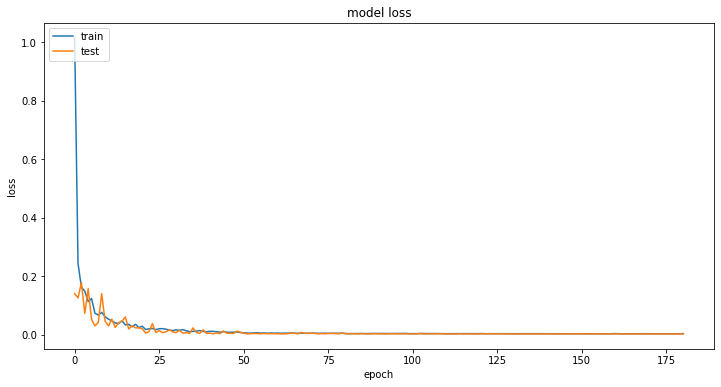

In [64]:
plot_history(history)

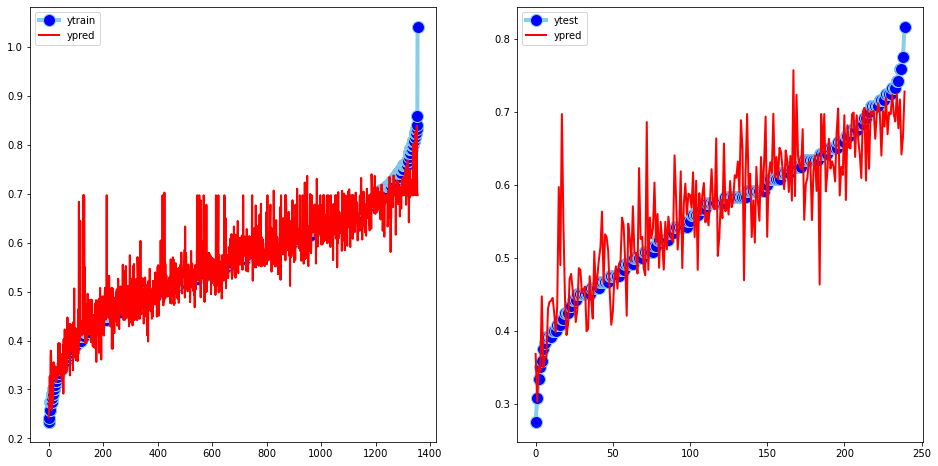

In [65]:
eval_model(nn_morg_model_trained, x_morg_train,
           y_morg_train.reshape(len(y_morg_train),1),
           x_morg_test,
           y_morg_test.reshape(len(y_morg_test),1))

# DAYLIGHT

In [66]:
nn_day_model = create_nn_model()
nn_day_model_trained, history = trainer(nn_day_model, x_day_train,
                                        np.array(y_day_train).reshape(len(y_day_train),1))


Epoch 00001: LearningRateScheduler reducing learning rate to 1.0.
Epoch 1/200
36/36 [==============================] - 1s 28ms/step - loss: 1.7145 - mean_squared_error: 1.7145 - val_loss: 1.6526 - val_mean_squared_error: 1.6526 - lr: 1.0000

Epoch 00002: LearningRateScheduler reducing learning rate to 1.0.
Epoch 2/200
36/36 [==============================] - 1s 16ms/step - loss: 0.3040 - mean_squared_error: 0.3040 - val_loss: 2.1394 - val_mean_squared_error: 2.1394 - lr: 1.0000

Epoch 00003: LearningRateScheduler reducing learning rate to 1.0.
Epoch 3/200
36/36 [==============================] - 1s 16ms/step - loss: 0.2641 - mean_squared_error: 0.2641 - val_loss: 2.4464 - val_mean_squared_error: 2.4464 - lr: 1.0000

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0.
Epoch 4/200
36/36 [==============================] - 1s 28ms/step - loss: 0.2006 - mean_squared_error: 0.2006 - val_loss: 0.5160 - val_mean_squared_error: 0.5160 - lr: 1.0000

Epoch 00005: LearningRateSchedu


Epoch 00035: LearningRateScheduler reducing learning rate to 1.0.
Epoch 35/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0193 - mean_squared_error: 0.0193 - val_loss: 0.0122 - val_mean_squared_error: 0.0122 - lr: 1.0000

Epoch 00036: LearningRateScheduler reducing learning rate to 1.0.
Epoch 36/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0180 - mean_squared_error: 0.0180 - val_loss: 0.0143 - val_mean_squared_error: 0.0143 - lr: 1.0000

Epoch 00037: LearningRateScheduler reducing learning rate to 1.0.
Epoch 37/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 0.0173 - val_mean_squared_error: 0.0173 - lr: 1.0000

Epoch 00038: LearningRateScheduler reducing learning rate to 1.0.
Epoch 38/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0125 - mean_squared_error: 0.0125 - val_loss: 0.0082 - val_mean_squared_error: 0.0082 - lr: 1.0000

Epoch 00039: LearningRateSc


Epoch 00069: LearningRateScheduler reducing learning rate to 0.5.
Epoch 69/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - lr: 0.5000

Epoch 00070: LearningRateScheduler reducing learning rate to 0.5.
Epoch 70/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - lr: 0.5000

Epoch 00071: LearningRateScheduler reducing learning rate to 0.5.
Epoch 71/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0069 - mean_squared_error: 0.0069 - val_loss: 0.0068 - val_mean_squared_error: 0.0068 - lr: 0.5000

Epoch 00072: LearningRateScheduler reducing learning rate to 0.5.
Epoch 72/200
36/36 [==============================] - 1s 25ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - lr: 0.5000

Epoch 00073: LearningRateSc

36/36 [==============================] - 1s 17ms/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - lr: 0.2500

Epoch 00103: LearningRateScheduler reducing learning rate to 0.25.
Epoch 103/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - lr: 0.2500

Epoch 00104: LearningRateScheduler reducing learning rate to 0.25.
Epoch 104/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - lr: 0.2500

Epoch 00105: LearningRateScheduler reducing learning rate to 0.25.
Epoch 105/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - lr: 0.2500

Epoch 00106: LearningRateScheduler reducing learning rate to 0.25.
Epoch 106/200
36/36 [=============

36/36 [==============================] - 1s 16ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - lr: 0.1250

Epoch 00136: LearningRateScheduler reducing learning rate to 0.125.
Epoch 136/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - lr: 0.1250

Epoch 00137: LearningRateScheduler reducing learning rate to 0.125.
Epoch 137/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0041 - mean_squared_error: 0.0041 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - lr: 0.1250

Epoch 00138: LearningRateScheduler reducing learning rate to 0.125.
Epoch 138/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - lr: 0.1250

Epoch 00139: LearningRateScheduler reducing learning rate to 0.125.
Epoch 139/200
36/36 [=========

36/36 [==============================] - 1s 17ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - lr: 0.0625

Epoch 00169: LearningRateScheduler reducing learning rate to 0.0625.
Epoch 169/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0040 - mean_squared_error: 0.0040 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - lr: 0.0625

Epoch 00170: LearningRateScheduler reducing learning rate to 0.0625.
Epoch 170/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - lr: 0.0625

Epoch 00171: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 171/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - lr: 0.0312

Epoch 00172: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 172/200
36/36 [===

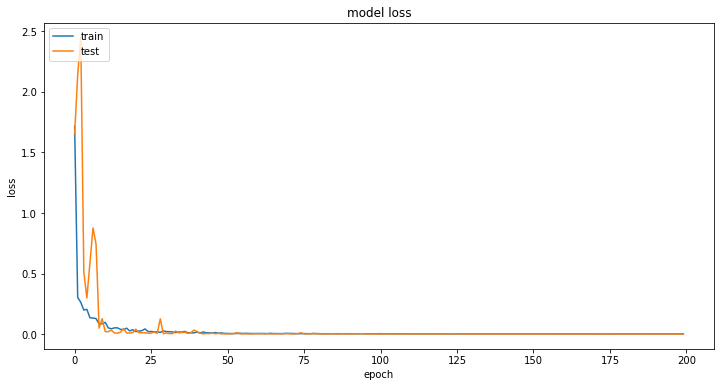

In [67]:
plot_history(history)

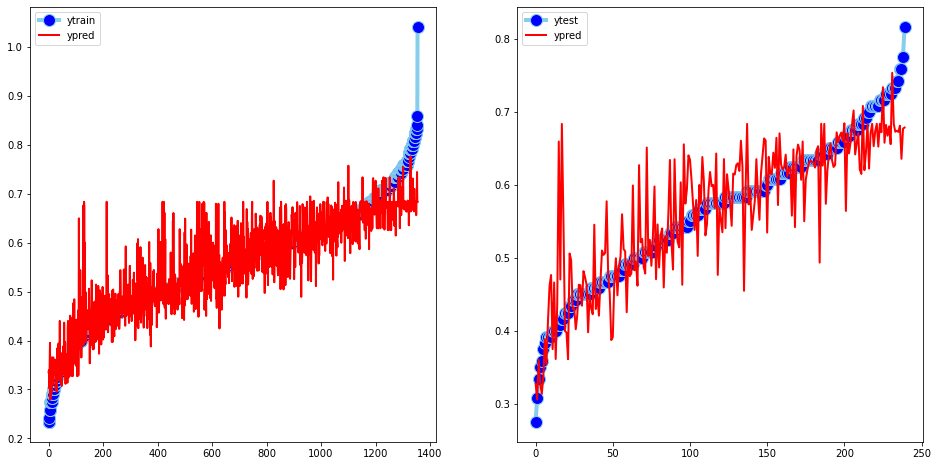

In [68]:
eval_model(nn_day_model_trained, x_day_train,
           np.array(y_day_train).reshape(len(y_day_train),1),
           x_day_test,
           np.array(y_day_test).reshape(len(y_day_test),1))

# ATOM PAIR

In [69]:
nn_atom_model = create_nn_model()
nn_atom_model_trained, history = trainer(nn_atom_model, x_atom_train,
                                         np.array(y_atom_train).reshape(len(y_atom_train),1))


Epoch 00001: LearningRateScheduler reducing learning rate to 1.0.
Epoch 1/200
36/36 [==============================] - 1s 28ms/step - loss: 0.9104 - mean_squared_error: 0.9104 - val_loss: 0.9779 - val_mean_squared_error: 0.9779 - lr: 1.0000

Epoch 00002: LearningRateScheduler reducing learning rate to 1.0.
Epoch 2/200
36/36 [==============================] - 1s 25ms/step - loss: 0.2352 - mean_squared_error: 0.2352 - val_loss: 0.1904 - val_mean_squared_error: 0.1904 - lr: 1.0000

Epoch 00003: LearningRateScheduler reducing learning rate to 1.0.
Epoch 3/200
36/36 [==============================] - 1s 26ms/step - loss: 0.1642 - mean_squared_error: 0.1642 - val_loss: 0.1313 - val_mean_squared_error: 0.1313 - lr: 1.0000

Epoch 00004: LearningRateScheduler reducing learning rate to 1.0.
Epoch 4/200
36/36 [==============================] - 1s 16ms/step - loss: 0.1359 - mean_squared_error: 0.1359 - val_loss: 0.2010 - val_mean_squared_error: 0.2010 - lr: 1.0000

Epoch 00005: LearningRateSchedu


Epoch 00035: LearningRateScheduler reducing learning rate to 1.0.
Epoch 35/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0113 - mean_squared_error: 0.0113 - val_loss: 0.0046 - val_mean_squared_error: 0.0046 - lr: 1.0000

Epoch 00036: LearningRateScheduler reducing learning rate to 1.0.
Epoch 36/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0182 - mean_squared_error: 0.0182 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - lr: 1.0000

Epoch 00037: LearningRateScheduler reducing learning rate to 1.0.
Epoch 37/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0090 - val_mean_squared_error: 0.0090 - lr: 1.0000

Epoch 00038: LearningRateScheduler reducing learning rate to 1.0.
Epoch 38/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - lr: 1.0000

Epoch 00039: LearningRateSc


Epoch 00069: LearningRateScheduler reducing learning rate to 0.5.
Epoch 69/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - lr: 0.5000

Epoch 00070: LearningRateScheduler reducing learning rate to 0.5.
Epoch 70/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0053 - mean_squared_error: 0.0053 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - lr: 0.5000

Epoch 00071: LearningRateScheduler reducing learning rate to 0.5.
Epoch 71/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0050 - mean_squared_error: 0.0050 - val_loss: 0.0057 - val_mean_squared_error: 0.0057 - lr: 0.5000

Epoch 00072: LearningRateScheduler reducing learning rate to 0.5.
Epoch 72/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0043 - val_mean_squared_error: 0.0043 - lr: 0.5000

Epoch 00073: LearningRateSc

36/36 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - lr: 0.2500

Epoch 00103: LearningRateScheduler reducing learning rate to 0.25.
Epoch 103/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0032 - val_mean_squared_error: 0.0032 - lr: 0.2500

Epoch 00104: LearningRateScheduler reducing learning rate to 0.25.
Epoch 104/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0036 - mean_squared_error: 0.0036 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - lr: 0.2500

Epoch 00105: LearningRateScheduler reducing learning rate to 0.25.
Epoch 105/200
36/36 [==============================] - 1s 17ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - lr: 0.2500

Epoch 00106: LearningRateScheduler reducing learning rate to 0.25.
Epoch 106/200
36/36 [=============

36/36 [==============================] - 1s 17ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - lr: 0.1250

Epoch 00136: LearningRateScheduler reducing learning rate to 0.125.
Epoch 136/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - lr: 0.1250

Epoch 00137: LearningRateScheduler reducing learning rate to 0.125.
Epoch 137/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0033 - val_mean_squared_error: 0.0033 - lr: 0.1250

Epoch 00138: LearningRateScheduler reducing learning rate to 0.125.
Epoch 138/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - lr: 0.1250

Epoch 00139: LearningRateScheduler reducing learning rate to 0.125.
Epoch 139/200
36/36 [=========

36/36 [==============================] - 1s 17ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - lr: 0.0625

Epoch 00169: LearningRateScheduler reducing learning rate to 0.0625.
Epoch 169/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0030 - val_mean_squared_error: 0.0030 - lr: 0.0625

Epoch 00170: LearningRateScheduler reducing learning rate to 0.0625.
Epoch 170/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - lr: 0.0625

Epoch 00171: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 171/200
36/36 [==============================] - 1s 16ms/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0029 - val_mean_squared_error: 0.0029 - lr: 0.0312

Epoch 00172: LearningRateScheduler reducing learning rate to 0.03125.
Epoch 172/200
36/36 [===

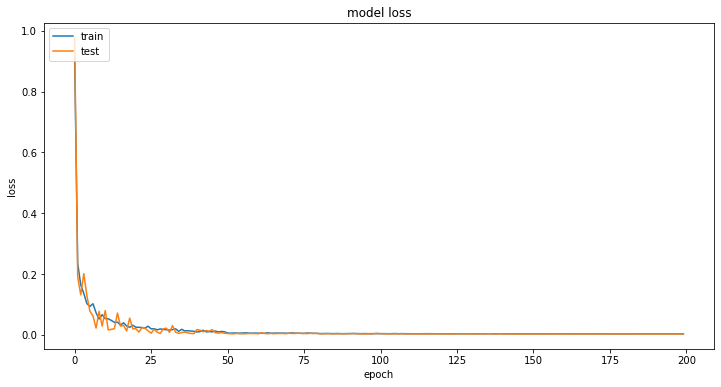

In [70]:
plot_history(history)

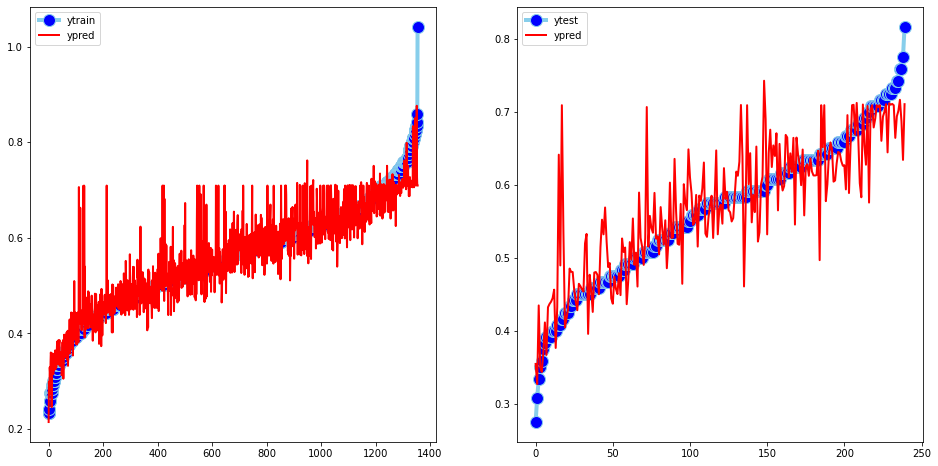

In [71]:
eval_model(nn_atom_model_trained, x_atom_train,
           np.array(y_atom_train).reshape(len(y_atom_train),1),
           x_atom_test,
           np.array(y_atom_test).reshape(len(y_atom_test),1))

# TORSION

In [ ]:
nn_tor_model = create_nn_model()
nn_tor_model_trained, history = trainer(nn_tor_model, x_tor_train,
                                         np.array(y_tor_train).reshape(len(y_tor_train),1))

In [ ]:
plot_history(history)

In [ ]:
eval_model(nn_tor_model_trained, x_tor_train,
           np.array(y_tor_train).reshape(len(y_tor_train),1),
           x_tor_test,
           np.array(y_tor_test).reshape(len(y_tor_test),1))


# CHEMICAL SIMILARITY

In [72]:
def findMostLike(fileName, k=10):
    drug = Chem.MolFromPDBFile(fileName)
    fp_ref = Chem.RDKFingerprint(drug)
    fda = Chem.SDMolSupplier('fda_stok.sdf')
    fingerprints = [Chem.RDKFingerprint(m) for m in fda]
    sim = [DataStructs.TanimotoSimilarity(fp_ref,fp) for fp in fingerprints]
    index = np.argsort(sim)[-k:]
    return frame.iloc[index,:], [sim[i] for i in index]

In [73]:
def findMostLikeMG(fileName,radius=1, nBits=2048, useChirality=True, k=10):
    drug = Chem.MolFromPDBFile(fileName)
    fp_ref = Chem.GetMorganFingerprintAsBitVect(drug, radius=radius,
                                                        nBits=nBits,
                                                        useChirality=useChirality)
    fda = Chem.SDMolSupplier('fda_stok.sdf')
    fingerprints = [Chem.GetMorganFingerprintAsBitVect(m, radius=radius,
                                                        nBits=nBits,
                                                        useChirality=useChirality) for m in fda]
    sim = [DataStructs.TanimotoSimilarity(fp_ref,fp) for fp in fingerprints]
    index = np.argsort(sim)[-k:]
    return frame.iloc[index,:], [sim[i] for i in index]

In [74]:
def findMostLikeAP(fileName, k=10):
    drug = Chem.MolFromPDBFile(fileName)
    fp_ref = Chem.GetHashedAtomPairFingerprintAsBitVect(drug)
    fda = Chem.SDMolSupplier('fda_stok.sdf')
    fingerprints = [Chem.GetHashedAtomPairFingerprintAsBitVect(m) for m in fda]
    sim = [DataStructs.TanimotoSimilarity(fp_ref,fp) for fp in fingerprints]
    index = np.argsort(sim)[-k:]
    return frame.iloc[index,:]

In [75]:
def findMostLikeTorsion(fileName, k=10):
    drug = Chem.MolFromPDBFile(fileName)
    fp_ref = Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(drug)
    fda = Chem.SDMolSupplier('fda_stok.sdf')
    fingerprints = [Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(m) for m in fda]
    sim = [DataStructs.TanimotoSimilarity(fp_ref,fp) for fp in fingerprints]
    index = np.argsort(sim)[-k:]
    return frame.iloc[index,:]

,zinc_id,SMILES,mol
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
96,ZINC000052955754,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

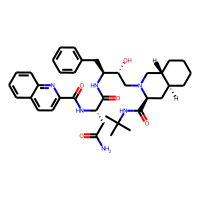
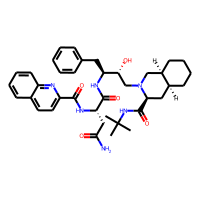
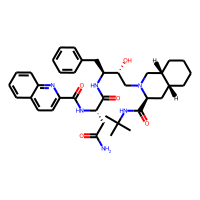
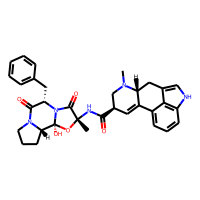
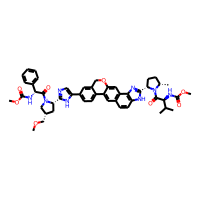
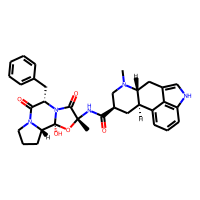
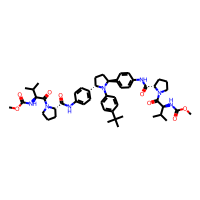
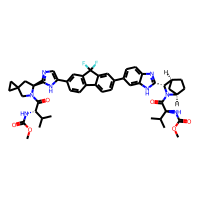
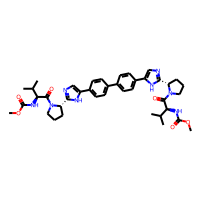
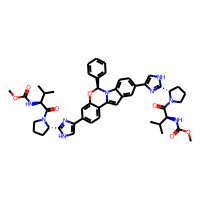

In [76]:
findMostLikeTorsion('DRI-C21041.pdb')

,zinc_id,SMILES,mol
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

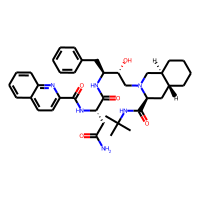
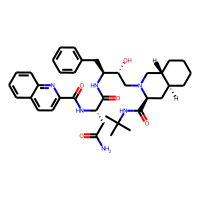
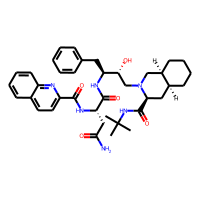
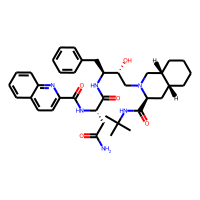
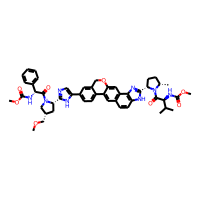
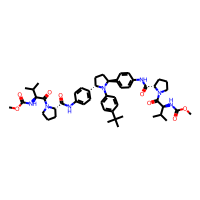
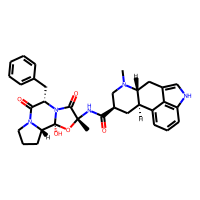
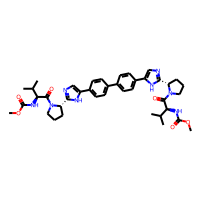
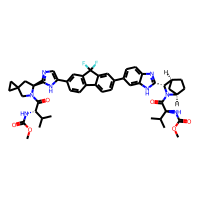
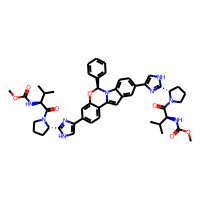

In [77]:
findMostLikeTorsion('DRI-C23041.pdb')

,zinc_id,SMILES,mol
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
96,ZINC000052955754,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

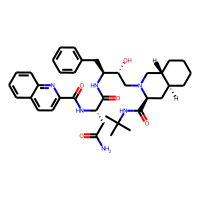
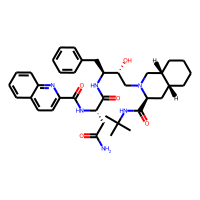
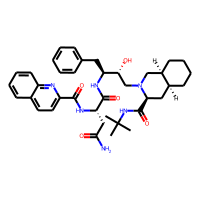
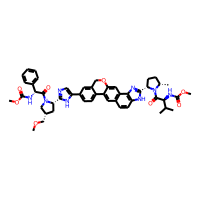
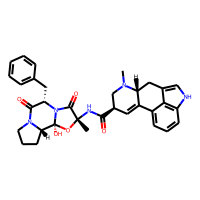
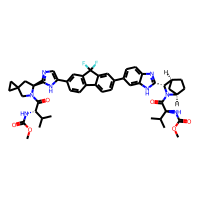
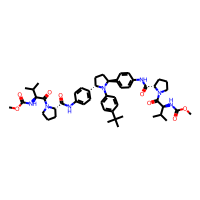
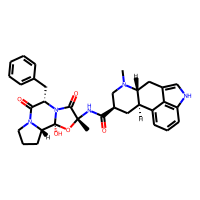
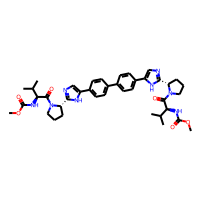
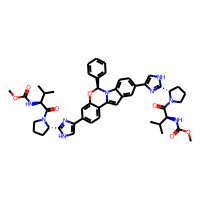

In [78]:
findMostLikeTorsion('DRI-C24041.pdb')

,zinc_id,SMILES,mol
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
96,ZINC000052955754,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

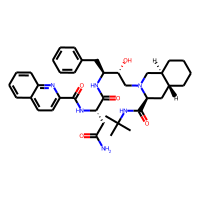
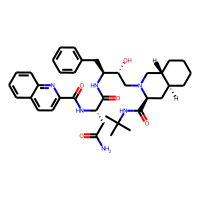
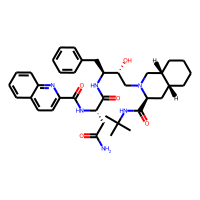
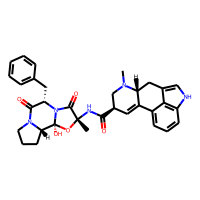
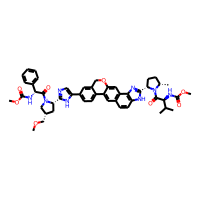
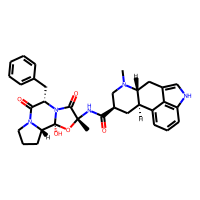
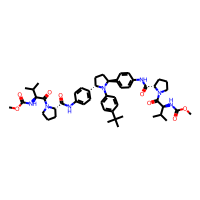
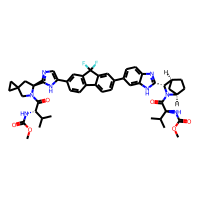
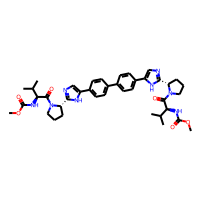
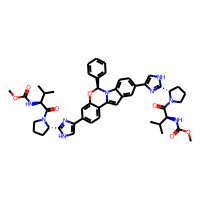

In [79]:
findMostLikeTorsion('DRI-C61041.pdb')

,zinc_id,SMILES,mol
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
96,ZINC000052955754,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

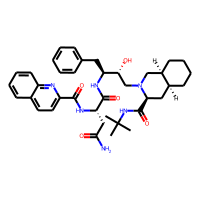
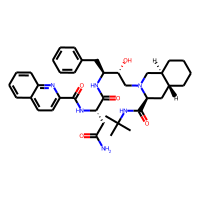
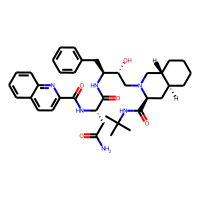
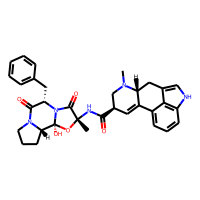
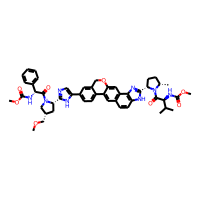
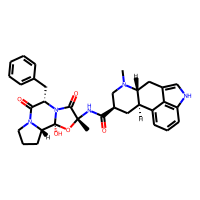
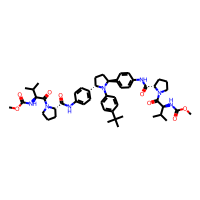
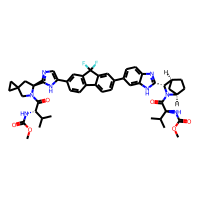
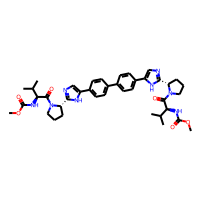
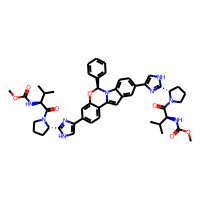

In [80]:
findMostLikeTorsion('DRI-C71041.pdb')

,zinc_id,SMILES,mol
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

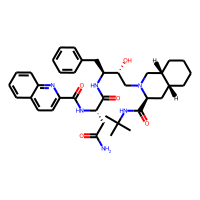
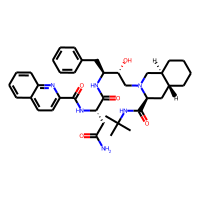
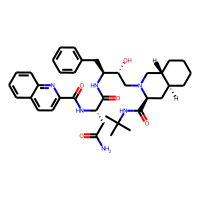
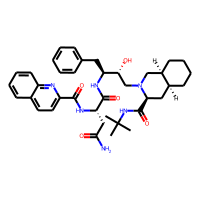
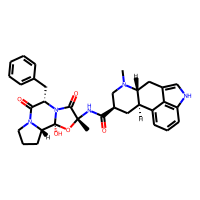
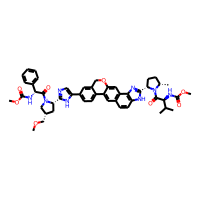
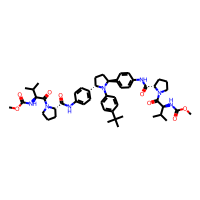
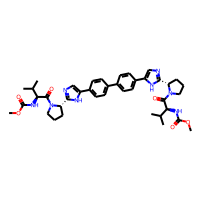
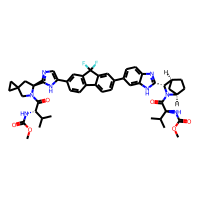
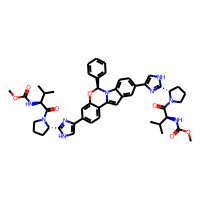

In [81]:
findMostLikeTorsion('DRI-C91005.pdb')

,zinc_id,SMILES,mol
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

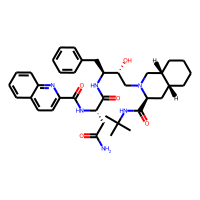
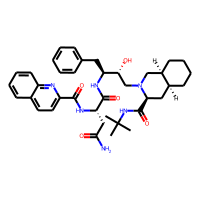
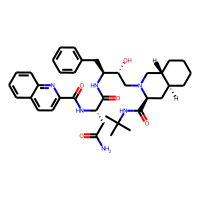
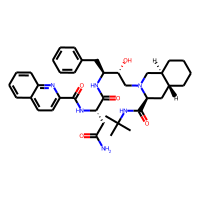
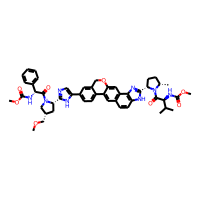
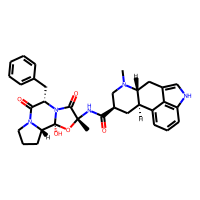
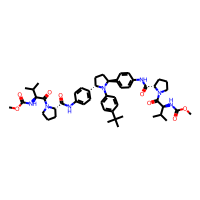
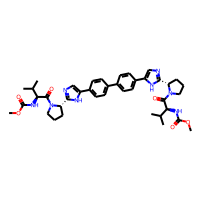
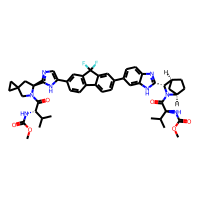
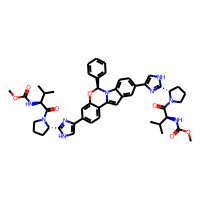

In [82]:
findMostLikeTorsion('DRI-C2204745.pdb')

,zinc_id,SMILES,mol
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
96,ZINC000052955754,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

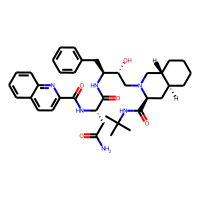
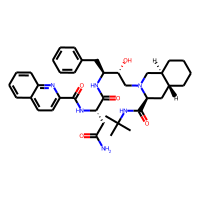
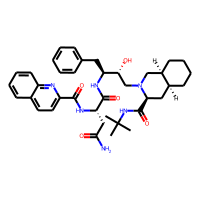
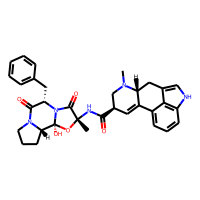
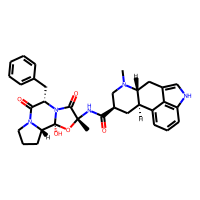
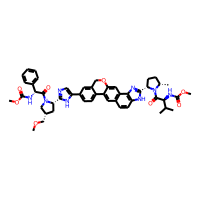
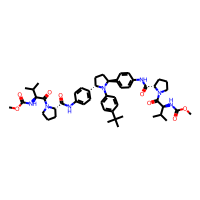
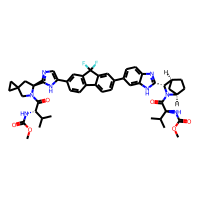
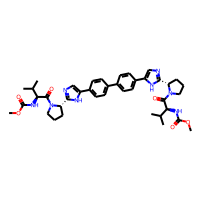
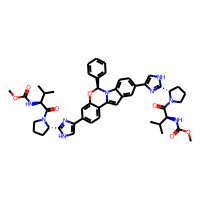

In [83]:
findMostLikeTorsion('Erythrosine B.pdb ')

,zinc_id,SMILES,mol
430,ZINC000003914596,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...,
272,ZINC000026664090,CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...,
274,ZINC000026985532,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...,
119,ZINC000029416466,CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...,
909,ZINC000003978005,CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...,
285,ZINC000203686879,COC[C@H]1C[C@@H](c2ncc(-c3ccc4c(c3)COc3cc5c(cc...,
1552,ZINC000150601177,COC(=O)N[C@H](C(=O)N1CCC[C@H]1C(=O)Nc1ccc([C@@...,
165,ZINC000068204830,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1ncc(-c2ccc(-c3...,
763,ZINC000150338819,COC(=O)N[C@H](C(=O)N1CC2(CC2)C[C@H]1c1ncc(-c2c...,
50,ZINC000150588351,COC(=O)N[C@H](C(=O)N1CCC[C@H]1c1nc(-c2ccc3c(c2...,

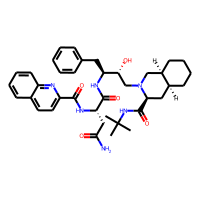
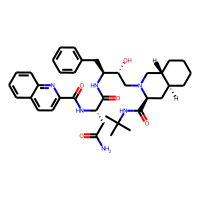
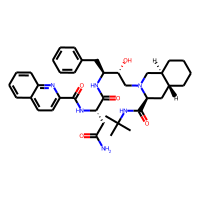
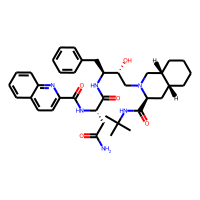
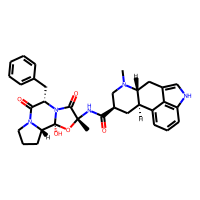
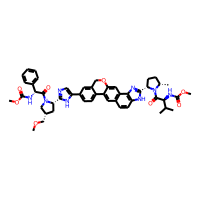
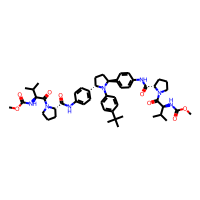
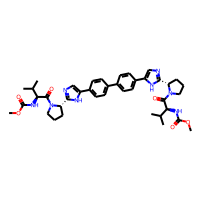
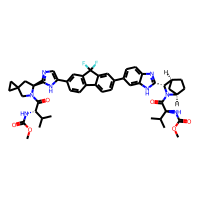
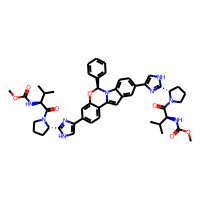

In [84]:
findMostLikeTorsion('Methylene Blue.pdb')

In [85]:
findMostLike('DRI-C21041.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [86]:
findMostLike('DRI-C23041.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [87]:
findMostLike('DRI-C24041.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 1596  <img data-conte

In [88]:
findMostLike('DRI-C61041.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [89]:
findMostLike('DRI-C71041.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [90]:
findMostLike('DRI-C91005.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [91]:
findMostLike('DRI-C2204745.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [92]:
findMostLike('Erythrosine B.pdb ')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 415   <img data-conte

In [93]:
findMostLike('Methylene Blue.pdb')

(               zinc_id                                             SMILES  \
 1354  ZINC000169621215  CO[C@H]1/C=C\O[C@@]2(C)Oc3c(C)c(O)c4c(c3C2=O)C...   
 1596  ZINC000150338708  COc1cc2c(cc1O)CCN[C@]21CS[C@@H]2c3c(OC(C)=O)c(...   
 415   ZINC000100378061  CC(C)(NC(=O)C1=C(O)[C@@H]2Oc3c(O)ccc4c3[C@@]23...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 987   ZINC000087496429  CCC1=C[C@@H]2CN(C1)Cc1c([nH]c3ccccc13)[C@@](C(...   
 1356  ZINC000085555528  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 1437  ZINC000085432544  CC[C@]1(O)C[C@@H]2CN(CCc3c([nH]c4ccccc34)[C@@]...   
 631   ZINC000085432549  CC[C@]1(O)C[C@H]2CN(CCc3c([nH]c4ccccc34)[C@@](...   
 
                                                     mol  
 1354  <img data-content="rdkit/molecule" src="data:i...  
 1596  <img data-conte

In [94]:
findMostLikeMG('DRI-C21041.pdb')

(               zinc_id                                             SMILES  \
 513   ZINC000003951740  Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)...   
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 
                                                     mol  
 513   <img data-content="rdkit/molecule" src="data:i...  
 1238  <img data-conte

In [95]:
findMostLikeMG('DRI-C23041.pdb')

(               zinc_id                                             SMILES  \
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 1238  <img data-content="rdkit/molecule" src="data:i...  
 96    <img data-conte

In [96]:
findMostLikeMG('DRI-C24041.pdb')

(               zinc_id                                             SMILES  \
 513   ZINC000003951740  Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)...   
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 
                                                     mol  
 513   <img data-content="rdkit/molecule" src="data:i...  
 1238  <img data-conte

In [97]:
findMostLikeMG('DRI-C61041.pdb')

(               zinc_id                                             SMILES  \
 513   ZINC000003951740  Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)...   
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 513   <img data-content="rdkit/molecule" src="data:i...  
 1238  <img data-conte

In [98]:
findMostLikeMG('DRI-C71041.pdb')

(               zinc_id                                             SMILES  \
 513   ZINC000003951740  Cc1cccc(C)c1OCC(=O)N[C@@H](Cc1ccccc1)[C@@H](O)...   
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 513   <img data-content="rdkit/molecule" src="data:i...  
 1238  <img data-conte

In [99]:
findMostLikeMG('DRI-C91005.pdb')

(               zinc_id                                             SMILES  \
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 1238  <img data-content="rdkit/molecule" src="data:i...  
 96    <img data-conte

In [100]:
findMostLikeMG('DRI-C2204745.pdb')

(               zinc_id                                             SMILES  \
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 1238  <img data-content="rdkit/molecule" src="data:i...  
 909   <img data-conte

In [101]:
findMostLikeMG('Erythrosine B.pdb ')

(               zinc_id                                             SMILES  \
 1377  ZINC000022448696  CC(C)(C)NC(=O)[C@@H]1CN(Cc2cccnc2)CCN1C[C@@H](...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 
                                                     mol  
 1377  <img data-content="rdkit/molecule" src="data:i...  
 881   <img data-conte

In [102]:
findMostLikeMG('Methylene Blue.pdb')

(               zinc_id                                             SMILES  \
 1238  ZINC000003791297  CCOC(=O)[C@H](CCc1ccccc1)N[C@@H](C)C(=O)N1CCC[...   
 909   ZINC000003978005  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 96    ZINC000052955754  CN1C[C@H](C(=O)N[C@]2(C)O[C@@]3(O)[C@@H]4CCCN4...   
 881   ZINC000095619105  CC[C@@H](CO)NC(=O)[C@@H]1C=C2c3cccc4[nH]cc(c34...   
 879   ZINC000053683151  CC(C)C[C@H]1C(=O)N2CCC[C@H]2[C@]2(O)O[C@](NC(=...   
 1264  ZINC000003807172  C[C@H]1CNc2c(cccc2S(=O)(=O)N[C@@H](CCCNC(=N)N)...   
 274   ZINC000026985532  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@@H]2CN1C[C@...   
 272   ZINC000026664090  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@H]2CN1C[C@...   
 430   ZINC000003914596  CC(C)(C)NC(=O)[C@@H]1C[C@@H]2CCCC[C@@H]2CN1C[C...   
 119   ZINC000029416466  CC(C)(C)NC(=O)[C@@H]1C[C@H]2CCCC[C@H]2CN1C[C@@...   
 
                                                     mol  
 1238  <img data-content="rdkit/molecule" src="data:i...  
 909   <img data-conte